# Plot

> A collection of plot functions

In [ ]:
#| default_exp plot

In [ ]:
#| hide
import sys
sys.path.append('/notebooks/katlas')
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from katlas.feature import *
from katlas.core import *
from fastbook import *
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import logomaker

import joblib
from adjustText import adjust_text
from pathlib import Path

/usr/local/lib/python3.9/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [ ]:
#| export
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

## Plot single kinase

### Logo

In [ ]:
#| export
#| hide
def logo_func(df, 
              title = 'logo'):
    "Functions of plotting logo"
    
    sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
    sns.set_context('notebook')
    sns.set_style("ticks")
    aa = {
        'AG': '#037f04',
        'DEty': '#da143e',
        'F': '#84380b',
        'HQN': '#8d2be1',
        'LMIFWTVC': '#d9a41c',
        'P': '#000000',
        'RK': '#0000ff',
        'ST': '#8d008d',
        'Y': '#84380b',
        # 'pS/pT':'#8d2be1',
        # 'pY':'#8d2be1'
    }
    logo = logomaker.Logo(df,color_scheme = aa,flip_below=False,figsize=(5.5,2.5))
    # logo.style_spines(visible=False)
    logo.style_xticks(fmt='%d')
    logo.ax.set_yticks([])
    # logo.ax.set_xticks([])
    # logo.ax.set_ylabel("log2[ratio to median]")
    # logo.ax.set_xlabel("Position")
    logo.ax.set_title(title)
    
    plt.show()
    plt.close()

In [ ]:
#| export
def get_logo(df, # Stacked Dataframe with kinase as index, substrates as columns
             kinase, # A specific kinase name in index
               ):
    "Given stacked df (index as kinase, columns as substrates), get specific kinase's logo"
    
    
    #get raw kinase to calculate S/T
    pp = get_one_kinase(df,kinase,normalize=False)
    
    #get S/T ratio value
    ss = pp['S'].sum()
    st = pp['T'].sum()

    S_ctrl = 0.75*ss - 0.25*st
    T_ctrl = 0.75*st - 0.25*ss

    S0 = S_ctrl / max(S_ctrl, T_ctrl)
    T0 = T_ctrl / max(S_ctrl, T_ctrl)

    S_ratio = S0/(S0+T0)
    T_ratio = T0/(S0+T0)
    
    #get normalized kinase
    norm_p = get_one_kinase(df,kinase, normalize=True)
    
    ratio =norm_p.apply(lambda r: r/r.median(),axis=1)

    ratio = np.log2(ratio)

    m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()

    new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m}, index=[0]) 

    ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)
    
    #plot logo
    logo_func(ratio2, kinase)

In [ ]:
raw = Data.get_stack_raw().set_index('kinase')

In [ ]:
raw.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,4493053.86,10062728.22,3327454.51,3504742.95,2767294.24,10105742.33,5923673.04,2909152.87,1695155.97,1617848.59,2128670.48,2128670.48,6460994.89,5260312.92,6325834.43,6957993.77,5369434.90,5713920.54,6612201.68,6093662.03,6120308.98,7306988.18,6829677.84,5119221.55,5263235.93,3974771.07,5065007.89,7968511.43,7041049.08,6174443.51,4228327.20,3271230.67,5511933.84,3267817.62,3267817.62,3338569.94,8921287.46,4210322.63,9202467.84,5247517.95,6741480.38,6810877.54,5271476.43,4928031.78,4337561.80,6432256.95,4006022.34,3383022.36,3493591.45,3269349.53,4253143.83,4777087.04,5719013.51,4787112.42,2233864.71,3045337.18,2489664.19,2489664.19,2253600.17,2216028.59,2766177.13,5269960.36,5606488.15,5715776.94,8442376.88,3330815.96,3699660.08,5573758.37,11418739.19,3289921.82,3904724.03,2831767.59,5548344.99,5749698.72,5431820.79,14853623.17,7911791.51,7877660.92,6228872.38,2050311.16,2050311.16,4757608.56,12743566.74,7922825.91,4320088.81,3424101.65,2951131.47,3531424.24,4395648.71,4876361.62,7337788.35,6213208.09,6110446.84,8716736.64,4935259.96,7723412.28,13791485.68,10359621.72,4456718.79,4865705.32,1811253.16,1639403.12,1357999.07,1357999.07,2002371.19,6415286.88,99964895.25,4316874.96,3007074.62,2745785.51,8910120.32,1483692.44,1412340.64,1811600.47,1711244.81,1783236.05,1979521.48,2246919.31,2217612.04,2688447.64,3450817.64,1911929.56,2358432.64,1421652.45,1359587.84,1706013.09,1706013.09,1389641.63,5119157.71,7278540.04,7284322.40,6474714.78,8229140.75,31325167.00,5271194.4,3595811.04,4019474.24,4672000.36,4719445.91,4458958.54,5560394.09,6019747.75,5603858.75,7520620.82,7492737.30,8100331.77,5364638.21,5087031.12,3976345.18,3976345.18,3984759.21,7873214.56,10666925.10,6726092.35,8347110.75,8474126.59,36243425.13,7049439.08,4480458.41,5646461.38,5049205.04,4966940.21,6154422.64,5554384.65,7784625.71,8536454.84,10411516.21,7199439.88,8496115.61,4678462.79,4293019.55,3871242.35,3871242.35,4144314.24,6754640.94,7548893.13,6945441.59,6316583.85,5852227.64,11986373.78,4544765.44,4468425.80,4958371.35,4992757.20,5630292.14,5605199.37,8889242.83,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,7217726.01,6944709.95,9655463.75,6855044.90,6135259.88,5714942.29,5174360.28,6446237.55,10676798.47,9490370.51,9417512.45,9417512.45,9143262.67,5189500.90,6115977.27,6183207.45,8746774.91,8620216.35,8958568.82,6057960.27,5865979.65,5795429.17,6425254.28,6896823.79,6528270.38,8404648.40,6144455.59,4524121.26,5095303.46,5374811.94,5585576.72,11592053.32,9685649.12,9011965.48,9011965.48,7594632.10,5362570.64,6972103.63,5730145.40,8939563.00,8882396.89,9190426.82,5827104.19,5369092.23,5113057.94,5497993.14,5506587.16,5872246.52,6306875.17,5653091.40,3785783.33,4917762.58,5423081.45,5362812.26,11212957.52,12861894.95,12864905.98,128

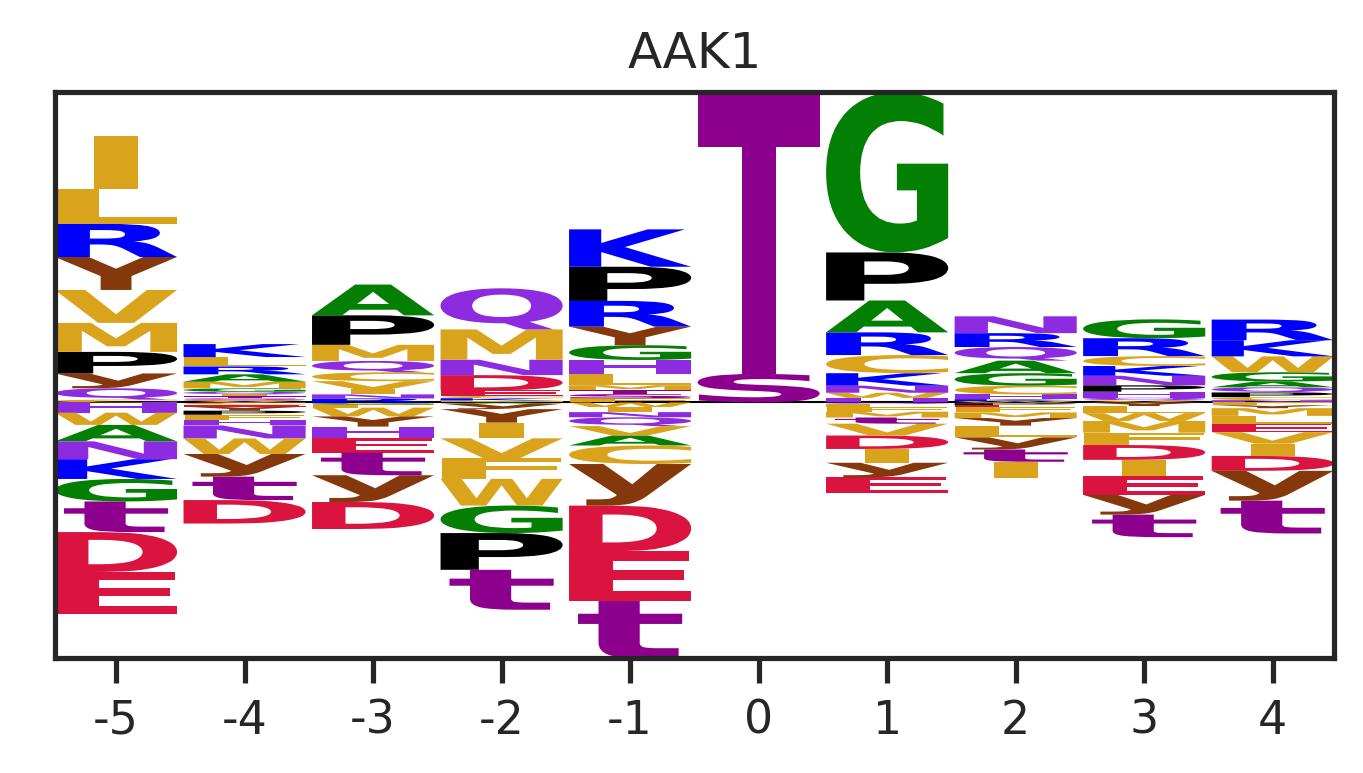

In [ ]:
get_logo(raw, 'AAK1')

### Heatmap

In [ ]:
#| export
def get_heatmap(df, # Stacked Dataframe with kinase as index, substrates as columns
                kinase # A specific kinase name in index
               ):
    aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEty']
    # position_order = [str(i) for i in range(-5,5)]
    # position_order.remove('0')
    
    kk = get_one_kinase(df, kinase).T
    # kkk = kk.reindex(index=aa_order, columns=position_order)
    kkk = kk.reindex(index=aa_order)
    
    plt.figure(figsize=(6, 10))
    sns.heatmap(kkk, cmap='binary', annot=False)
    plt.title(kinase)
    plt.show()

In [ ]:
raw.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,4493053.86,10062728.22,3327454.51,3504742.95,2767294.24,10105742.33,5923673.04,2909152.87,1695155.97,1617848.59,2128670.48,2128670.48,6460994.89,5260312.92,6325834.43,6957993.77,5369434.90,5713920.54,6612201.68,6093662.03,6120308.98,7306988.18,6829677.84,5119221.55,5263235.93,3974771.07,5065007.89,7968511.43,7041049.08,6174443.51,4228327.20,3271230.67,5511933.84,3267817.62,3267817.62,3338569.94,8921287.46,4210322.63,9202467.84,5247517.95,6741480.38,6810877.54,5271476.43,4928031.78,4337561.80,6432256.95,4006022.34,3383022.36,3493591.45,3269349.53,4253143.83,4777087.04,5719013.51,4787112.42,2233864.71,3045337.18,2489664.19,2489664.19,2253600.17,2216028.59,2766177.13,5269960.36,5606488.15,5715776.94,8442376.88,3330815.96,3699660.08,5573758.37,11418739.19,3289921.82,3904724.03,2831767.59,5548344.99,5749698.72,5431820.79,14853623.17,7911791.51,7877660.92,6228872.38,2050311.16,2050311.16,4757608.56,12743566.74,7922825.91,4320088.81,3424101.65,2951131.47,3531424.24,4395648.71,4876361.62,7337788.35,6213208.09,6110446.84,8716736.64,4935259.96,7723412.28,13791485.68,10359621.72,4456718.79,4865705.32,1811253.16,1639403.12,1357999.07,1357999.07,2002371.19,6415286.88,99964895.25,4316874.96,3007074.62,2745785.51,8910120.32,1483692.44,1412340.64,1811600.47,1711244.81,1783236.05,1979521.48,2246919.31,2217612.04,2688447.64,3450817.64,1911929.56,2358432.64,1421652.45,1359587.84,1706013.09,1706013.09,1389641.63,5119157.71,7278540.04,7284322.40,6474714.78,8229140.75,31325167.00,5271194.4,3595811.04,4019474.24,4672000.36,4719445.91,4458958.54,5560394.09,6019747.75,5603858.75,7520620.82,7492737.30,8100331.77,5364638.21,5087031.12,3976345.18,3976345.18,3984759.21,7873214.56,10666925.10,6726092.35,8347110.75,8474126.59,36243425.13,7049439.08,4480458.41,5646461.38,5049205.04,4966940.21,6154422.64,5554384.65,7784625.71,8536454.84,10411516.21,7199439.88,8496115.61,4678462.79,4293019.55,3871242.35,3871242.35,4144314.24,6754640.94,7548893.13,6945441.59,6316583.85,5852227.64,11986373.78,4544765.44,4468425.80,4958371.35,4992757.20,5630292.14,5605199.37,8889242.83,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,7217726.01,6944709.95,9655463.75,6855044.90,6135259.88,5714942.29,5174360.28,6446237.55,10676798.47,9490370.51,9417512.45,9417512.45,9143262.67,5189500.90,6115977.27,6183207.45,8746774.91,8620216.35,8958568.82,6057960.27,5865979.65,5795429.17,6425254.28,6896823.79,6528270.38,8404648.40,6144455.59,4524121.26,5095303.46,5374811.94,5585576.72,11592053.32,9685649.12,9011965.48,9011965.48,7594632.10,5362570.64,6972103.63,5730145.40,8939563.00,8882396.89,9190426.82,5827104.19,5369092.23,5113057.94,5497993.14,5506587.16,5872246.52,6306875.17,5653091.40,3785783.33,4917762.58,5423081.45,5362812.26,11212957.52,12861894.95,12864905.98,128

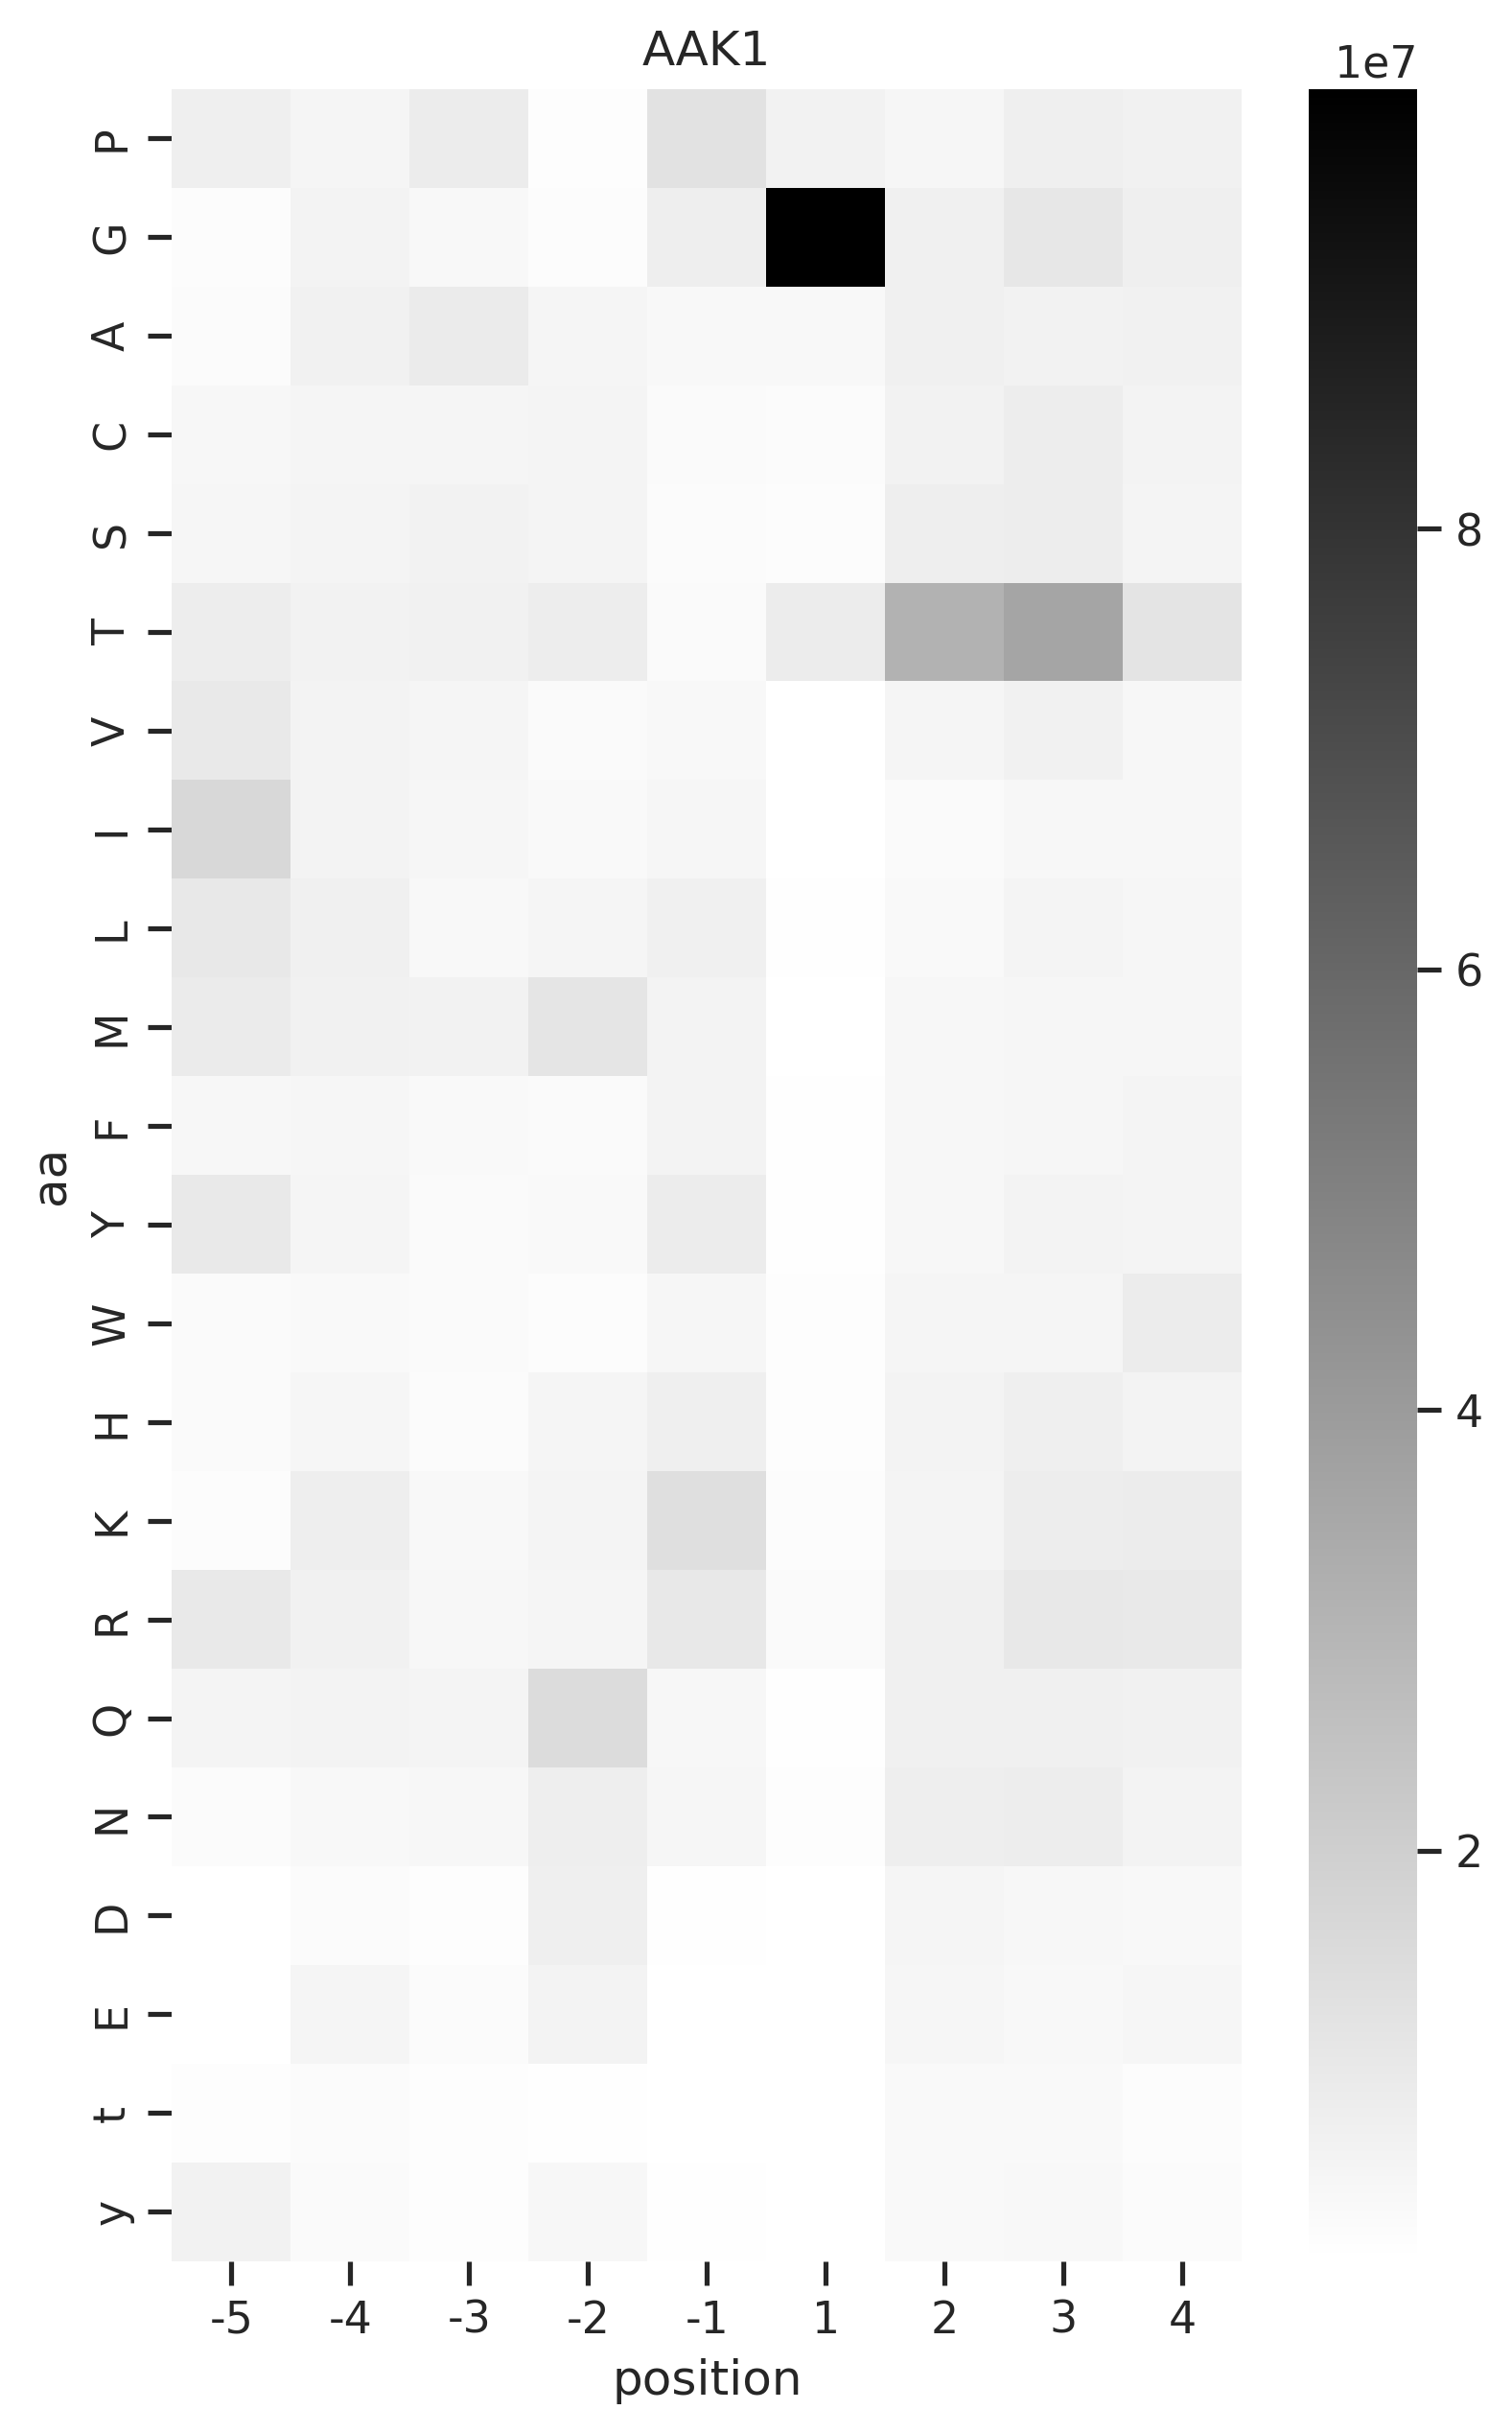

In [ ]:
get_heatmap(raw, 'AAK1')

## Visualize features in 2D

In [ ]:
#| export
def plot_cluster(df, # a dataframe with values, and index as identity
                 method='pca', # Could be 'tsne', 'umap'
                 hue=None,
                 complexity = 30, # 30 for tsne, 15 for umap, none for pca
                 palette='tab20', # could be tab10 if less categories
                 legend=False, 
                 name_list=None, # if not none, will annotate each dots in the plot
                 seed = 123
                ):
    
    "Given a dataframe of values, plot it in 2d, method could be pca, tsne, or umap"
    
    embedding_df = reduce_feature(df, method=method, seed=seed, complexity = complexity)
    # x_col, y_col = [col for col in embedding_df.columns if col.startswith(method.upper())]
    x_col, y_col = embedding_df.columns
    sns.relplot(data=embedding_df, x=x_col, y=y_col, hue=hue, palette=palette, s=50, alpha=0.8, legend=legend)
    plt.xticks([])
    plt.yticks([])
    if name_list is not None:
        texts = [plt.text(embedding_df[x_col][i], embedding_df[y_col][i], name_list[i],fontsize=8) for i in range(len(embedding_df))]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    plt.show()
    plt.close()

In [ ]:
df = Data.get_aa_feature().set_index('aa')
info=Data.get_aa_info()

In [ ]:
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,MinPartialCharge,MaxAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,HallKierAlpha,Kappa2,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA10,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA8,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState7,VSA_EState8,FractionCSP3,NumAliphaticHeterocycles,NumAromaticHeterocycles,NumHAcceptors,MolLogP,fr_Al_COO,fr_Al_OH,fr_C_O,fr_NH0,fr_NH1,fr_sulfide,fr_unbrch_alkane
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,9.574074,1.193554,0.430590,-0.375462,-1.439770,0.228166,-0.308911,1.656688,0.103007,-0.780051,-0.526903,1.203883,-1.415519,1.465101,-1.347549,1.162418,0.678178,-1.660842,0.058766,-0.928528,0.661861,-1.704924,-1.164169,-1.088274,-0.113045,-0.213201,-0.308607,-0.521596,-0.682582,-0.458413,-0.308393,-0.647398,-0.224260,-0.480351,-0.694405,-0.882977,-0.432331,-0.495561,-0.290532,-0.695145,-0.511968,-0.482124,-1.373429,-0.884527,-0.45843,-0.213201,-0.535127,-0.661160,-0.922850,-0.621218,-0.611041,-0.440926,-0.455591,-0.769976,-0.626017,-0.748232,-0.483822,0.342808,-0.462400,0.572190,0.349099,-0.213201,-0.308607,-1.192079,-0.082356,-0.308607,-0.308607,-0.458831,-0.213201,-0.428746,-0.213201,-0.308607
C,9.756435,-0.594121,0.396312,-0.623715,-0.643882,0.233514,-0.311825,1.656688,1.401076,0.150357,1.981889,1.146308,-0.628535,0.696026,-0.795604,0.077060,0.765682,-0.684106,0.233728,-0.790419,1.460660,-0.601392,-0.581437,-1.088274,-0.113045,-0.213201,-0.308607,-0.521596,-0.682582,-0.458413,3.364183,-0.647398,-1.107502,0.556864,-0.694405,2.015850,-0.432331,-0.495561,-1.340339,0.914158,-0.511968,-0.482124,-0.257709,-0.884527,-0.45843,-0.213201,-0.535127,-0.661160,0.310554,-0.621218,-0.611041,-0.440926,-0.455591,2.765813,-0.626017,-0.709478,-0.437633,0.631861,-0.462400,-0.522169,0.349099,-0.213201,-0.308607,0.331133,-0.196341,-0.308607,-0.308607,-0.458831,-0.213201,-0.428746,-0.213201,-0.308607
D,9.846435,0.536545,0.158193,-0.369303,-0.347487,0.037668,-0.205110,-1.033743,-1.273733,-1.372129,-0.525782,0.115873,0.346261,0.398995,-0.516138,-0.084662,-3.545366,-0.722995,0.822870,-0.281516,-0.547747,-0.442263,0.200980,0.373629,-0.113045,-0.213201,-0.308607,1.500960,1.050911,-0.458413,-0.308393,-0.647398,-1.107502,-0.480351,1.110102,0.487224,-0.432331,-0.495561,-0.366786,-0.695145,-0.511968,-0.482124,0.774640,0.433147,-0.45843,-0.213201,1.741627,1.556719,-0.922850,-0.621218,-0.611041,-0.440926,-0.455591,-0.769976,0.487402,1.474811,-0.483206,-2.651958,-0.936726,-0.522169,-0.429755,-0.213201,-0.308607,0.331133,-0.772086,3.240370,-0.308607,2.179449,-0.213201,-0.428746,-0.213201,-0.308607
E,9.993880,-1.144174,0.263960,-0.056770,0.000656,0.028134,-0.199915,-1.248978,-1.218664,-0.661636,-0.526379,-0.271923,0.069844,0.109885,-0.172745,0.256753,-0.437180,-0.085041,0.534017,-0.174262,-0.547747,0.361706,0.487383,0.373629,-0.113045,-0.213201,-0.308607,1.500960,1.050911,-0.458413,-0.308393,-0.647398,-0.288416,0.677296,-0.694405,0.487224,-0.432331,-0.495561,0.606766,-0.695145,-0.511968,-0.482124,0.774640,0.433147,-0.45843,-0.213201,0.561766,1.556719,1.830379,-0.621218,-0.611041,-0.440926,-0.455591,-0.769976,0.487402,1.540314,-0.410105,-2.063646,-0.662030,-0.522169,0.037557,-0.213201,-0.308607,0.331133,-0.278572,3.240370,-0.308607,2.179449,-0.213201,-0.428746,-0.213201,-0.308607
F,10.378642,0.050359,0.433525,1.825444,0.448946,0.231079,-0.310499,-1.168265,-0.723037,0.404105,-0.526883,-0.818551,-0.069808,-0.311742,0.192350,-0.048318,0.413831,0.726870,-1.313071,0.839266,-1.118318,0.399290,-0.669480,-1.088274,-0.113045,-0.213201,-0.308607,-0.521596,-0.6825

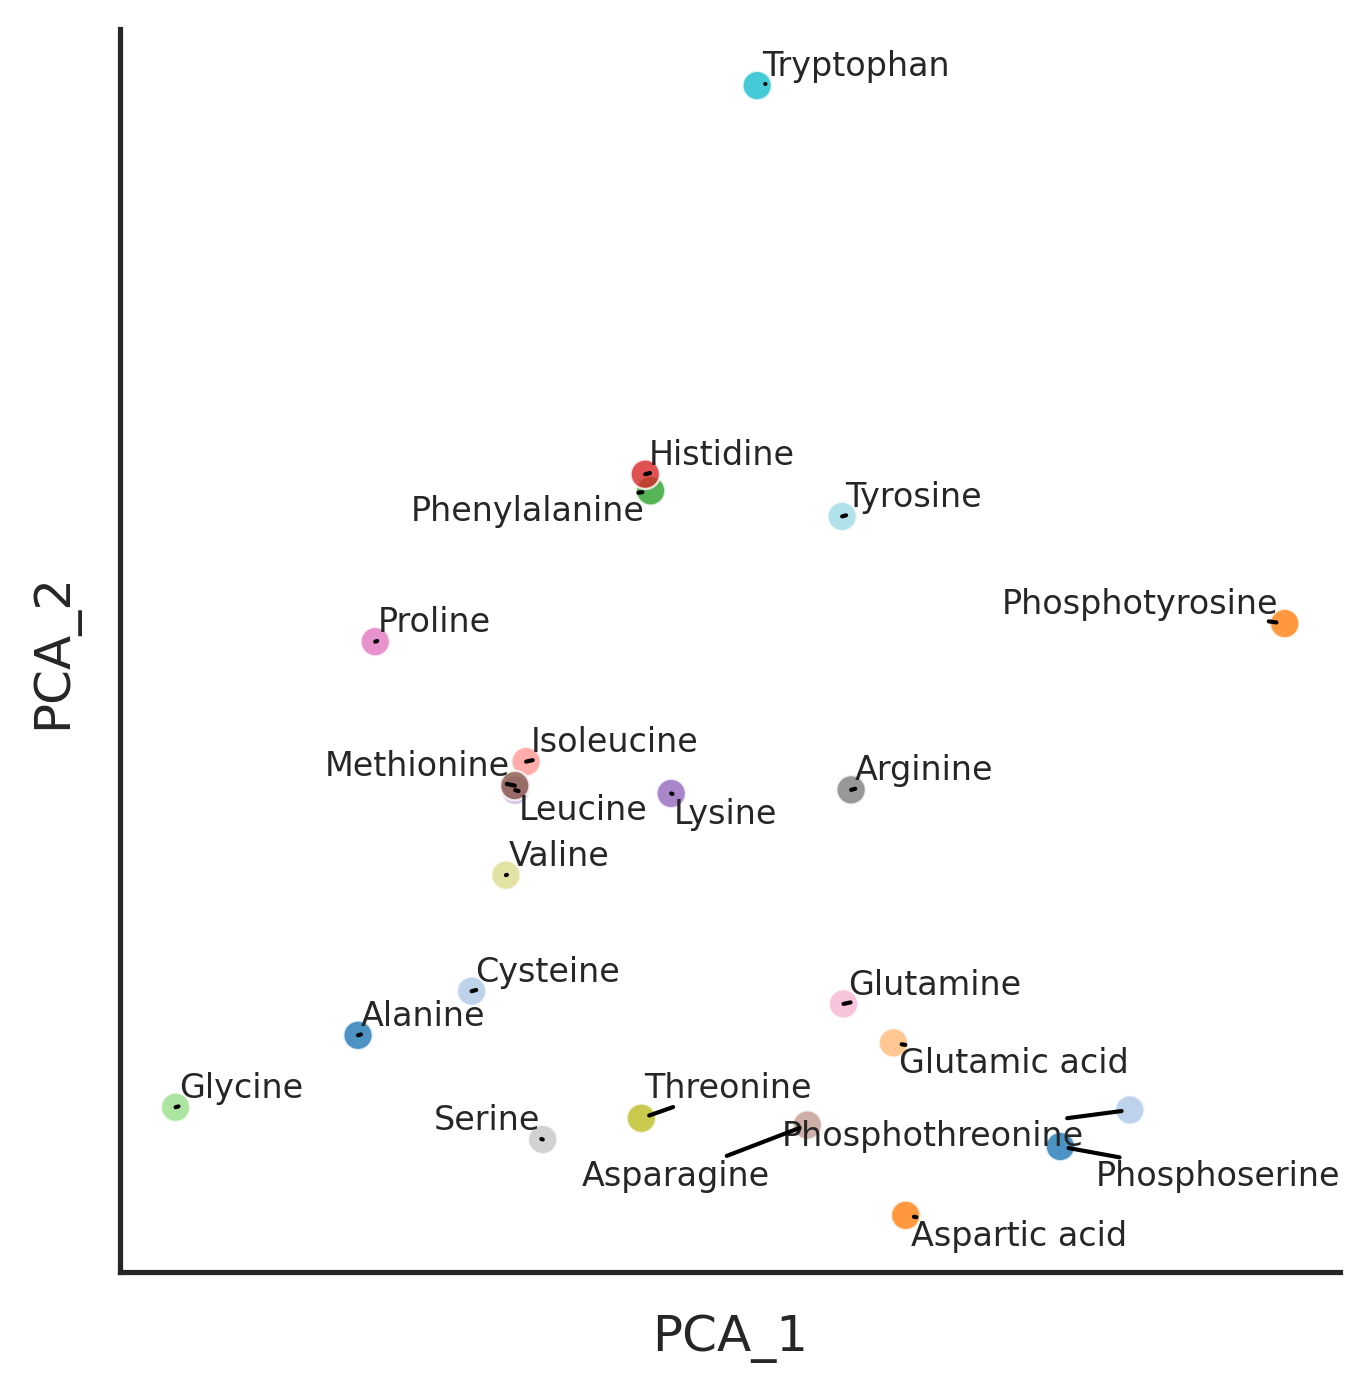

In [ ]:
plot_cluster(df, name_list = info.Name,hue='aa')

## Bar graph

In [ ]:
#| export
def plot_bar(df, # dataframe with a column of values, and a column of category to groupby
             values, # colname of values
             category, # colname of categories which is used to groupby values
             circle = True, # whether or not add dots in the graph
             aspect = 3 # the biger the value is, the wider the graph is
              ):
    
    order = df.groupby(category)[values].mean().sort_values(ascending=False).index
    g = sns.catplot(data=df,
                x=category,
                y=values,
                aspect=aspect,
                order=order,
                kind='bar',
                ci='sd',
                palette='tab20',)
    g.set_xticklabels(rotation=45)
    
    if circle:
        marker = {'marker': 'o', 
                  'color': 'white', 
                  'edgecolor': 'black', 
                  'linewidth': 1.5, 
                  's': 6}

        sns.stripplot(data=df, 
                      x=category, 
                      y=values,
                      order=order,
                      alpha=0.8,
                      ax=g.ax,
                      **marker);

In [ ]:
df2 = Data.get_unstack_log()

In [ ]:
df2.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,15.845517,-5,P
1,ACVR2A,-5P,15.423155,-5,P
2,ACVR2B,-5P,17.091913,-5,P
3,AKT1,-5P,16.727835,-5,P
4,AKT2,-5P,15.509150,-5,P


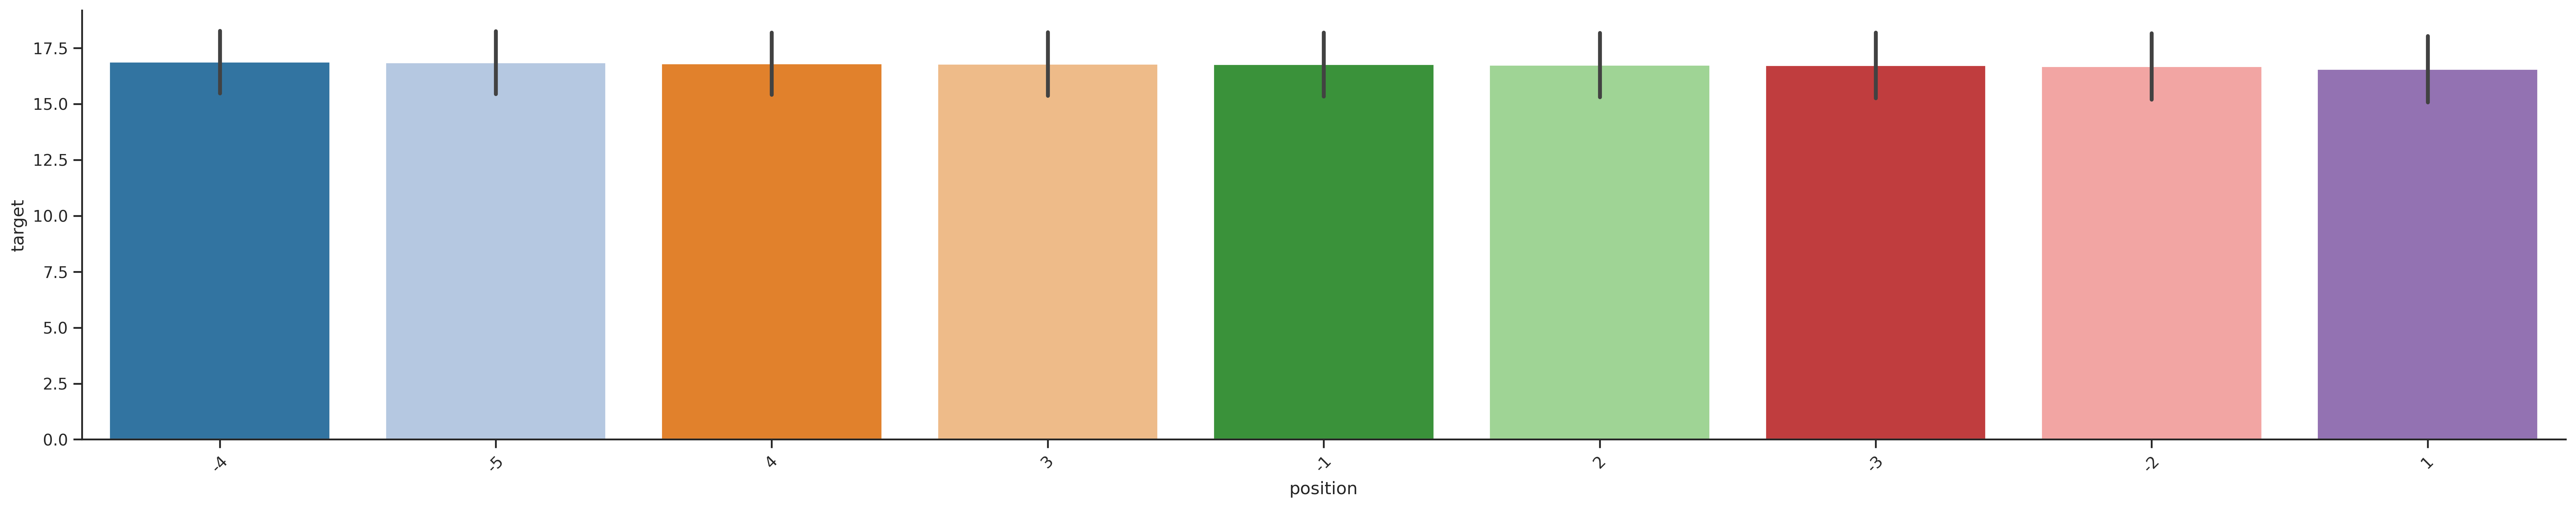

In [ ]:
plot_bar(df2,values='target',category='position',circle=False,aspect=5)

## Correlation graph with regression line

In [ ]:
#| export
def plot_corr(
              x,
              y,
              xlabel=None,# x axis label
              ylabel=None,# y axis label
              order=1, # polynomial level, if straight, order=1
              method = 'pearson', # can be spearman
             ):
    "Given a dataframe and the name of two columns, plot the two columns' correlation"
    
    if method == 'spearman':
        correlation, pvalue = spearmanr(x, y)
    elif method == 'pearson':
        correlation, pvalue = pearsonr(x, y)
    else:
        raise ValueError("Invalid correlation method. Choose 'spearman' or 'pearson'.")
        
    sns.regplot(
                x=x,
                y=y,
                order=order,
                line_kws={'color': 'gray'}
           )
    
    if xlabel is not None:
        plt.xlabel(xlabel)
        
    if ylabel is not None:
        plt.ylabel(ylabel)
    
    correlation_text = f'Spearman: {correlation:.2f}' if method == 'spearman' else f'Pearson: {correlation:.2f}'

    plt.text(x=0.8, y=0.1, s=correlation_text, transform=plt.gca().transAxes, ha='center', va='center')
    
    plt.show()
    plt.close()

In [ ]:
norm = Data.get_stack_norm().set_index('kinase')

In [ ]:
norm.head()

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,0.0720,0.0245,0.0284,0.0456,0.0425,0.0425,0.0951,0.1554,0.0993,0.0864,0.0425,0.0952,0.0315,0.0331,0.0262,0.0956,0.0560,0.0275,0.0160,0.0153,0.0201,0.0201,0.0611,0.0534,0.0642,0.0706,0.0560,0.0619,0.0619,0.0619,0.0621,0.0742,0.0693,0.0520,0.0534,0.0403,0.0514,0.0809,0.0715,0.0627,0.0429,0.0332,0.0560,0.0332,0.0332,0.0339,0.1084,0.0512,0.1119,0.0655,0.0527,0.0527,0.0641,0.0599,0.0527,0.0782,0.0487,0.0411,0.0425,0.0397,0.0517,0.0581,0.0695,0.0582,0.0272,0.0370,0.0303,0.0303,0.0274,0.0226,0.0283,0.0538,0.0588,0.0555,0.0555,0.0340,0.0378,0.0569,0.1166,0.0336,0.0399,0.0289,0.0567,0.0587,0.0555,0.1517,0.0808,0.0805,0.0636,0.0209,0.0209,0.0486,0.1136,0.0706,0.0385,0.0313,0.0545,0.0545,0.0392,0.0435,0.0654,0.0554,0.0545,0.0777,0.0440,0.0688,0.1229,0.0923,0.0397,0.0434,0.0161,0.0146,0.0121,0.0121,0.0178,0.0463,0.7216,0.0312,0.0223,0.0143,0.0143,0.0107,0.0102,0.0131,0.0124,0.0129,0.0143,0.0162,0.0160,0.0194,0.0249,0.0138,0.0170,0.0103,0.0098,0.0123,0.0123,0.0100,0.0527,0.0749,0.0750,0.0684,0.0552,0.0552,0.0542,0.0370,0.0414,0.0481,0.0486,0.0459,0.0572,0.0620,0.0577,0.0774,0.0771,0.0834,0.0552,0.0524,0.0409,0.0409,0.0410,0.0681,0.0923,0.0582,0.0742,0.0582,0.0582,0.0610,0.0388,0.0489,0.0437,0.0430,0.0533,0.0481,0.0674,0.0739,0.0901,0.0623,0.0735,0.0405,0.0371,0.0335,0.0335,0.0359,0.0628,0.0702,0.0646,0.0603,0.0560,0.0560,0.0422,0.0415,0.0461,0.0464,0.0523,0.0521,0.0826,0.0560,0.0831,0.0928,0.0635,0.0592,0.0389,0.0457,0.0251,0.0251,0.0270
ACVR2A,0.0415,0.0481,0.0584,0.0489,0.0578,0.0578,0.0598,0.0625,0.0596,0.0521,0.0600,0.0578,0.0803,0.0570,0.0510,0.0475,0.0430,0.0536,0.0888,0.0789,0.0783,0.0783,0.0760,0.0466,0.0549,0.0555,0.0551,0.0549,0.0549,0.0543,0.0526,0.0520,0.0576,0.0619,0.0586,0.0754,0.0551,0.0406,0.0457,0.0482,0.0501,0.1040,0.0869,0.0809,0.0809,0.0681,0.0502,0.0653,0.0537,0.0588,0.0516,0.0516,0.0546,0.0503,0.0479,0.0515,0.0516,0.0550,0.0591,0.0529,0.0355,0.0461,0.0508,0.0502,0.1050,0.1205,0.1205,0.1205,0.0975,0.0189,0.0294,0.0312,0.0726,0.0295,0.0295,0.0295,0.0267,0.0253,0.0234,0.0297,0.0293,0.0317,0.0287,0.0208,0.0297,0.0452,0.0398,0.2530,0.3077,0.0595,0.0595,0.0424,0.0398,0.0335,0.0484,0.1042,0.0630,0.0630,0.0650,0.0473,0.0750,0.0847,0.0688,0.0783,0.0816,0.0630,0.0313,0.0340,0.0529,0.0480,0.0724,0.0761,0.0807,0.0807,0.1065,0.0200,0.0338,0.0381,0.0748,0.0548,0.0548,0.0779,0.0691,0.0514,0.0586,0.0548,0.0571,0.0566,0.0412,0.0192,0.0245,0.0723,0.0375,0.0990,0.1888,0.2735,0.2735,0.1651,0.0582,0.0799,0.0660,0.0600,0.0582,0.0582,0.0588,0.0538,0.0397,0.0517,0.0578,0.0651,0.0578,0.0660,0.0473,0.0550,0.0591,0.0507,0.0728,0.0604,0.0650,0.0650,0.0516,0.0670,0.0592,0.0529,0.0481,0.0590,0.0590,0.0567,0.0554,0.0612,0.0589,0.0644,0.0654,0.0635,0.0590,0.0462,0.0387,0.0499,0.0524,0.0622,0.0870,0.0519,0.0519,0.0815,0.0758,0.0544,0.0498,0.0517,0.0563,0.0563,0.0516,0.0563,0.0512,0.0662,0.0523,0.0579,0.0800,0.0573,0.0527,0.0491,0.0616,0.0556,0.0640,0.0640,0.0703,0.0703,0.0589
ACVR2B,0.0533,0.0517,0.0566,0.0772,0.0533,0.0533,0.0543,0.0442,0.0471,0.0516,0.0604,0.0607,0.0721,0.0518,0.0432,0.0472,0.0498,0.0595,0.1065

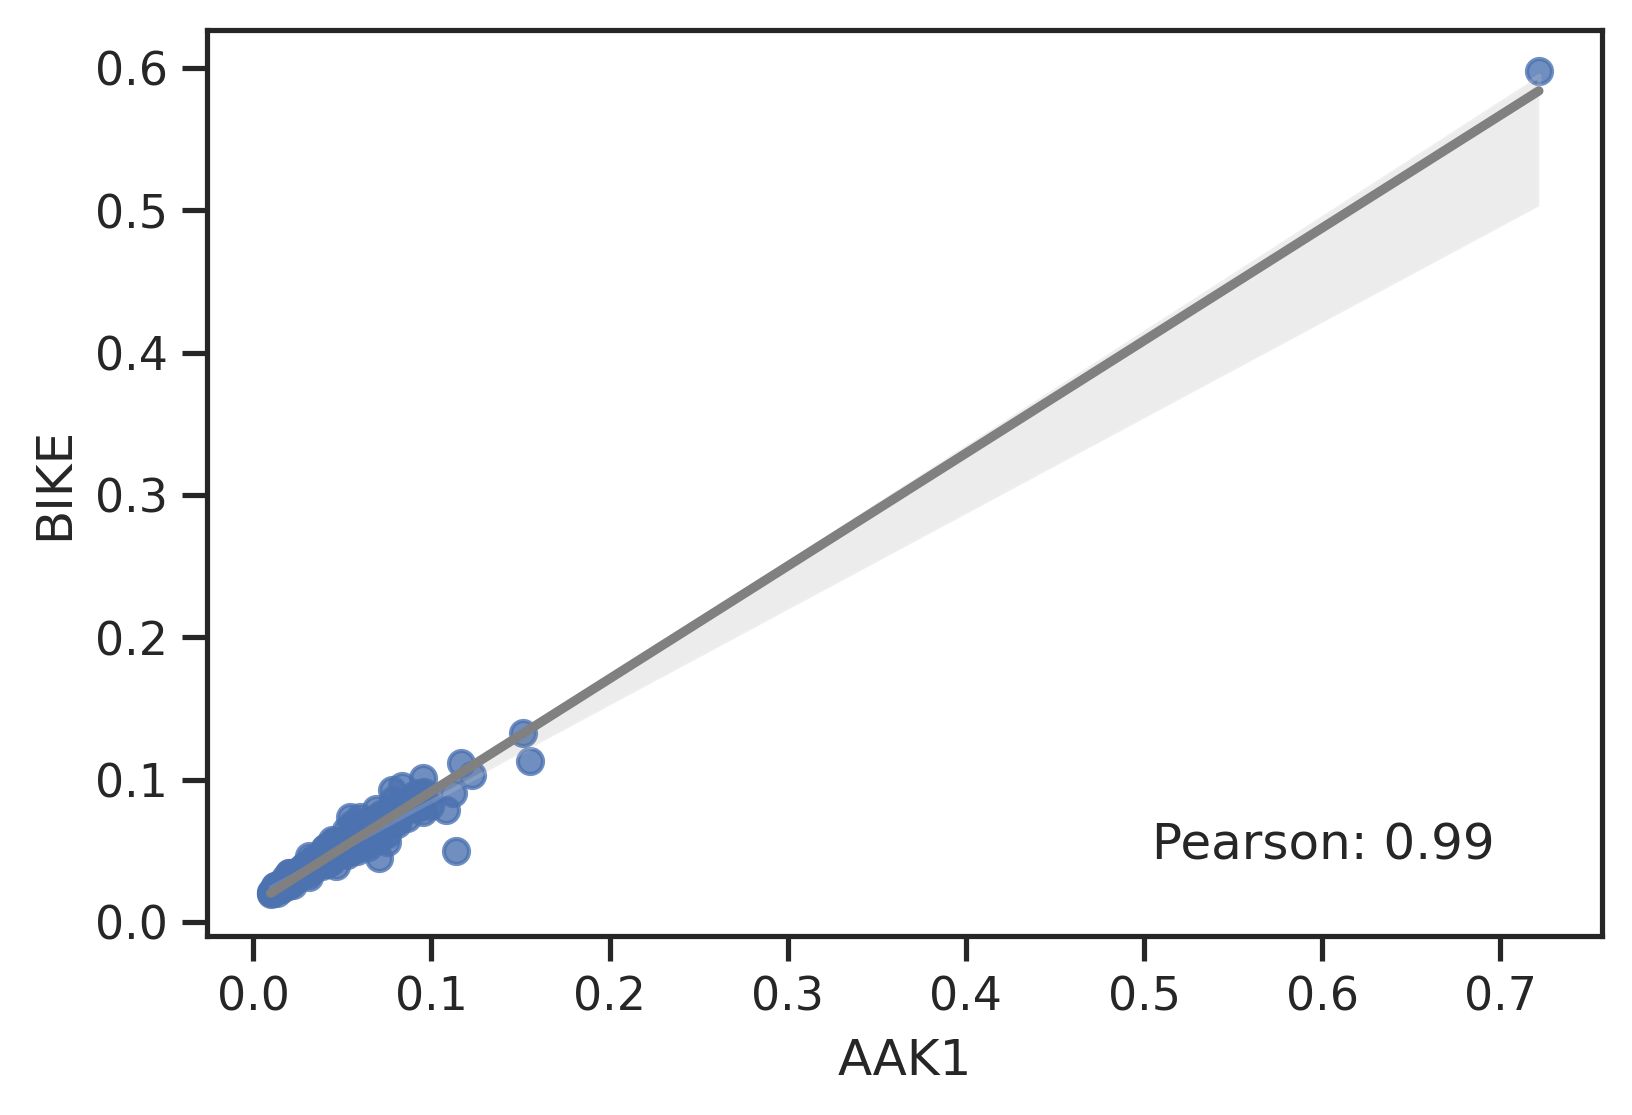

In [ ]:
plot_corr(norm.loc['AAK1'], norm.loc['BIKE'])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()